In [1]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn import preprocessing
# have to do this for art to work
tf.compat.v1.disable_eager_execution()

### Introduction  
After failing to create a lstm model that correctly classifies real minute tsla data in this notebook we will attempt to use a simple sine wave and see if we can get a higher accuracy.

In [2]:
x = np.arange(0,10000,0.1)
sx = np.sin(x)

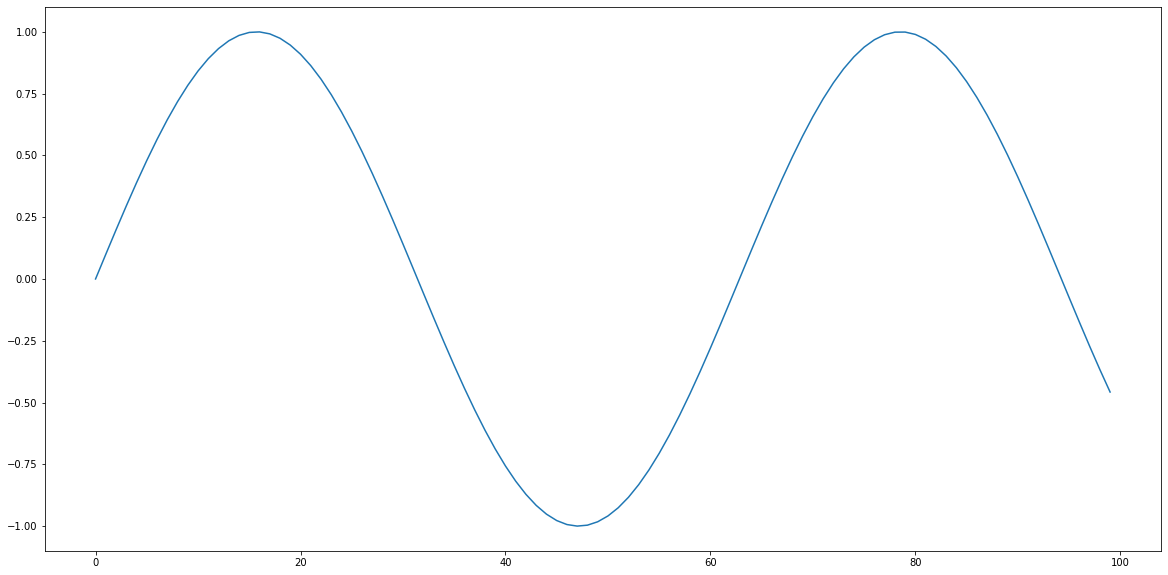

In [3]:
plt.plot(sx[:100])

In [4]:
# to turn the regression problem into a classification problem we have to make the y labels of a certain class
# lets split the data 'forecast' into ranges
print(sx.min(),sx.max())
# our data is from -1 to 1 and should have a good distrobution. So if we wanted to split into 3 classes
# we could get values from -1 to -.5, -.5 to 0, and 0 to .5, .5 to 1
for i in [-1,-.5,.0,.5]:
    print(i,np.count_nonzero(sx>i)-np.count_nonzero(sx<(i+.5)))

-0.9999999989777327 0.9999999998864147
-1 66677
-0.5 16693
0.0 -16643
0.5 -66658


In [36]:
# pushes all values into 4 classes, from 0 to 1 because that's what we scale it
def map_to_class(value):
    if value >= .75:
        return 3
    if value >= .5 and value < .75:
        return 2
    if value >= .25 and value < .5:
        return 1
    if value < .25:
        return 0
    print('error',value)
    return 0

In [6]:
dataset = pd.DataFrame(sx, columns=['value'])
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(map_to_class(dataset[i + look_back, 0]))
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [7]:
# we have a nice distrobution
np.unique(Y_train,return_counts=True)

(array([1, 2, 3, 4]), array([26663, 13327, 13334, 26645], dtype=int64))

In [10]:
X_train.shape

(79969, 1, 30)

In [11]:
X_test.shape

(19969, 1, 30)

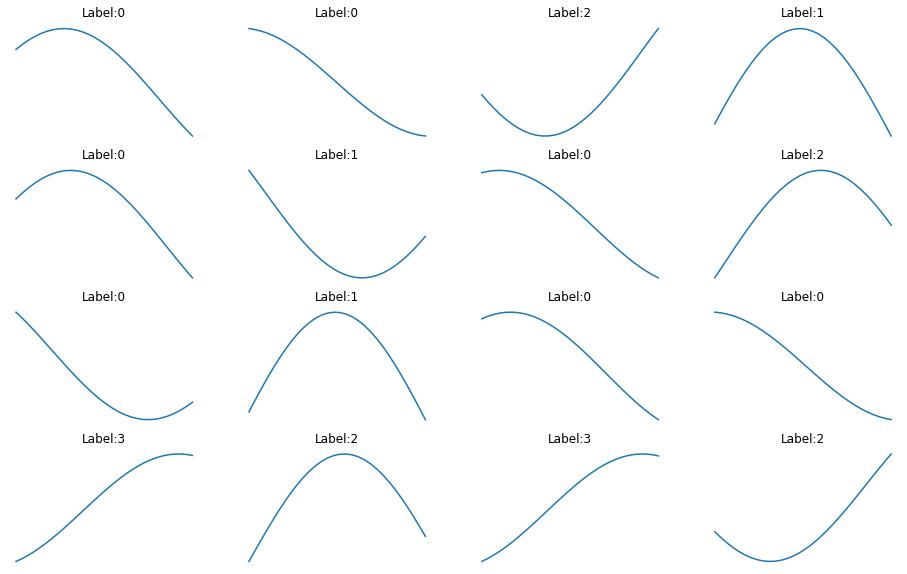

In [73]:
plt.figure(figsize=(16, 10))
for n in range(16):
    i = np.random.randint(0, len(X_train), 1)[0]
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_train[i, 0])
    plt.title('Label:' + str(Y_train[i]))
    plt.axis('off')

In [15]:
from tensorflow.keras.optimizers import *
model = Sequential()
# lstm layer
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(X_train.shape[2]))  
model.add(Dropout(0.5))  
# some dense layers
model.add(Dense(512,activation='relu'))  
# output layer
model.add(Dense(len(np.unique(Y_train)),activation='softmax')) # number of classes in Y

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate = 1e-4))

history = model.fit(X_train, Y_train, epochs=5, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)], verbose=1, shuffle=False)

model.summary()

Train on 79969 samples, validate on 19969 samples
Epoch 1/5
79730/79969 [============================>.] - ETA: 0s - loss: 0.3495 - accuracy: 0.8641

C:\ML\nvidiatf\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


79969/79969 [==============================] - 13s 162us/sample - loss: 0.3488 - accuracy: 0.8644 - val_loss: 0.0640 - val_accuracy: 0.9869
Epoch 2/5
79969/79969 [==============================] - 11s 138us/sample - loss: 0.0680 - accuracy: 0.9778 - val_loss: 0.0347 - val_accuracy: 0.9942
Epoch 3/5
79969/79969 [==============================] - 11s 140us/sample - loss: 0.0405 - accuracy: 0.9882 - val_loss: 0.0243 - val_accuracy: 0.9950
Epoch 4/5
79969/79969 [==============================] - 11s 140us/sample - loss: 0.0289 - accuracy: 0.9923 - val_loss: 0.0201 - val_accuracy: 0.9941
Epoch 5/5
79969/79969 [==============================] - 11s 140us/sample - loss: 0.0234 - accuracy: 0.9938 - val_loss: 0.0173 - val_accuracy: 0.9939
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               293888    
__________________________________________

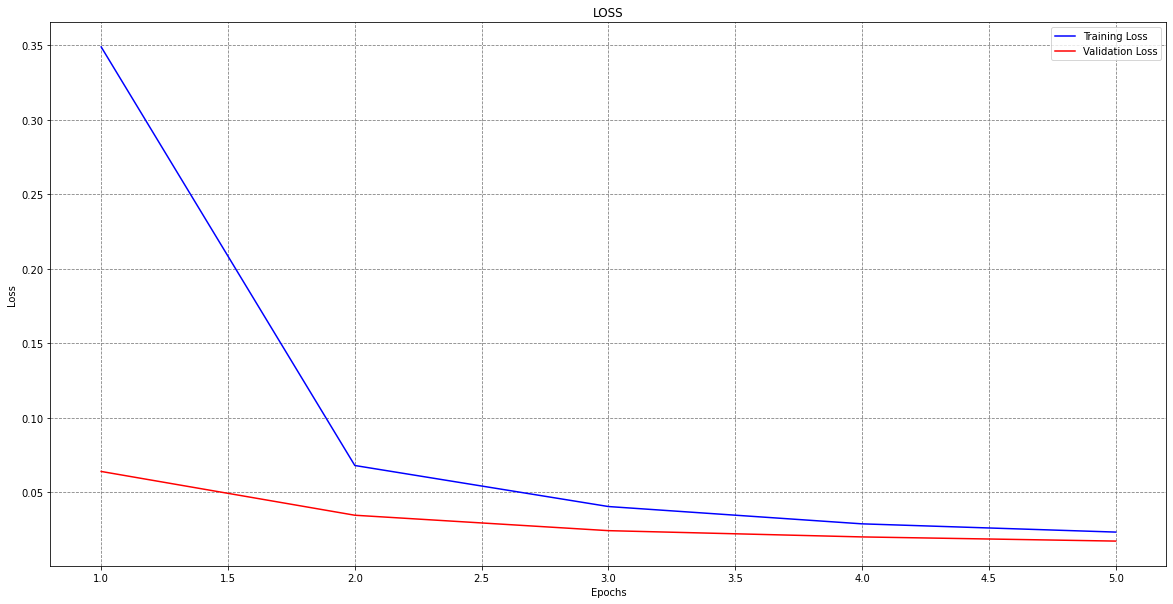

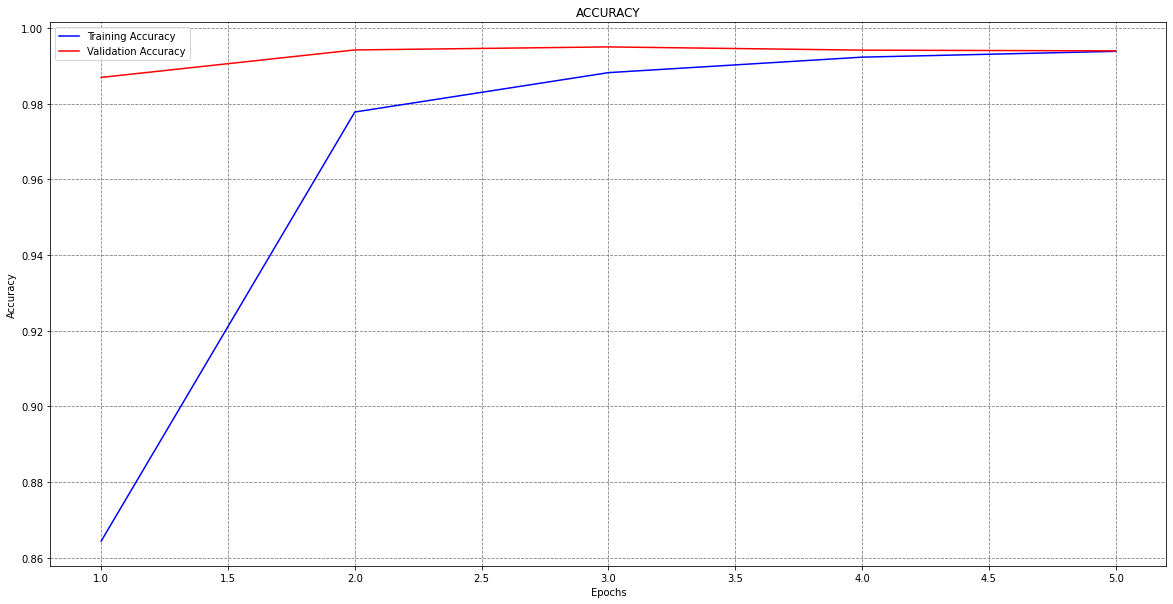

In [16]:
# PLot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show() 

In [17]:
!pip install adversarial-robustness-toolbox

You should consider upgrading via the 'C:\ML\nvidiatf\Scripts\python.exe -m pip install --upgrade pip' command.


In [18]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

In [19]:
classifier = KerasClassifier(model=model, use_logits=False)

In [22]:
# FGSM attack
epsilon = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8]

fgsm_attack_acc = []
fgsm_attacks = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_data = attack_fgsm.generate(X_test)
    fgsm_attacks.append(fgsm_attack_adv_data)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_data, Y_test)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_data - X_test)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 95.03%
Average perturbation: 0.01
Accuracy on adversarial test data: 86.55%
Average perturbation: 0.02
Accuracy on adversarial test data: 72.89%
Average perturbation: 0.05
Accuracy on adversarial test data: 47.76%
Average perturbation: 0.10
Accuracy on adversarial test data: 4.18%
Average perturbation: 0.20
Accuracy on adversarial test data: 0.40%
Average perturbation: 0.30
Accuracy on adversarial test data: 0.22%
Average perturbation: 0.50
Accuracy on adversarial test data: 0.18%
Average perturbation: 0.80


In [118]:
dfacc = pd.DataFrame([epsilon,fgsm_attack_acc])
dfacc = dfacc.transpose()
dfacc.columns = ['Epsilon','Accuracy']
dfacc.head()

,Epsilon,Accuracy
0,0.010,0.950323
1,0.025,0.865542
2,0.050,0.728880
3,0.100,0.477590
4,0.200,0.041815


### Analyze the attack  
The purpose of this whole exercise was to show a structure which could be used to predict when trading algorithms would fail causing 'flash crash' like effects in the stock market. So now we go over the attacks and try and find patterns

In [46]:
atk = fgsm_attacks[3] #purturbation epsilon .1 accuarcy 47
atk_y = model.predict(atk)
atk_y = np.argmax(atk_y, axis=1)
atk.shape

(19969, 1, 30)

In [47]:
acc = model.evaluate(atk,Y_test)
print(f'Accuracy at e=.1 is %.2f'%acc[1])

Accuracy at e=.1 is 0.48


In [49]:
atk_y[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [50]:
Y_test[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

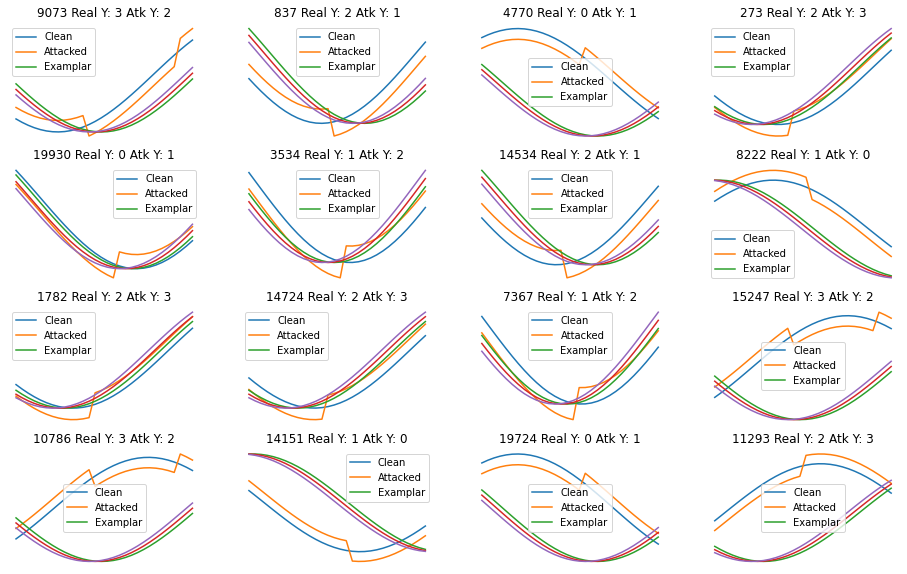

In [77]:
import random
plt.figure(figsize=(16, 10))
for n in range(16):
    # let's only focus on missed labeled examples
    misses = np.where(Y_test != atk_y)[0]
    #i = np.random.randint(0, len(misses), 1)[0]
    i = random.choice(misses)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.plot(X_test[examplar_ind[1], 0])
        plt.plot(X_test[examplar_ind[2], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')

### Conclusion #1  
It is pretty clear to see from the above data that the majority of the time the data is changed so much that it more corresponds to the mis classified class. In otherwords the purturbations in the attack simply push the data from one class into a different class and I do not think this is an occurance of miss classification, I think it is correctly classified. For example in the chart below the pertubed data has a smaller mse with the 'miss' classified class than the supposed actual target.

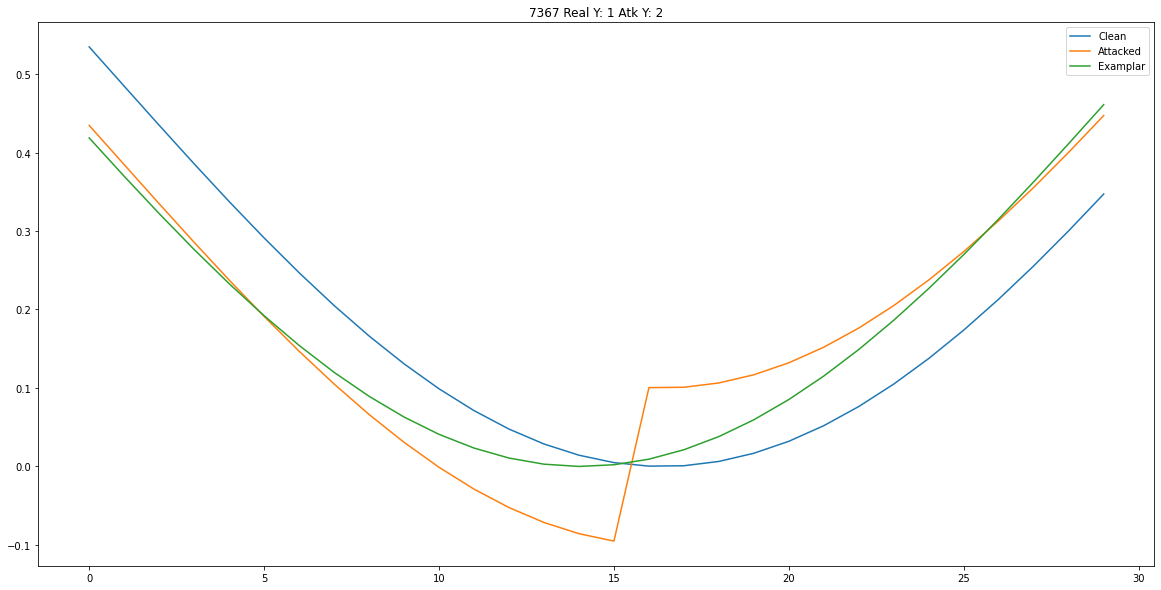

In [81]:
# look specific at why some of these are not actually miss classified
i = 7367
misses = np.where(Y_test != atk_y)[0]
plt.plot(X_test[i, 0])
plt.plot(atk[i, 0])
plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
plt.plot(X_test[examplar_ind[0], 0])
plt.legend(['Clean','Attacked','Examplar'])

In [85]:
# show that it's not actually a miss classifiction
from sklearn.metrics import mean_squared_error
# mse between the attack and the supposed actual target class
mse_base = mean_squared_error(X_test[i,0], atk[i,0])
# mse between the attack and the 'miss classification'
mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])

print(f'MSE base: %.4f, MSE target: %.4f'%(mse_base,mse_target))

MSE base: 0.0100, MSE target: 0.0020


Therefore this curve was much closer to the '2' class that it was miss labeled as. This shows one basic problem with the idea of this project. Obviously a change in the input data could simply make it closer to another target class, so just because an attack causes it to classify as another class does not necissarily mean that it is wrong.  
More interesting is the example below, this is clearly miss classified and it is much further from the miss classification than the actual class MSE .01 vs .407

MSE base: 0.0100, MSE target: 0.4073


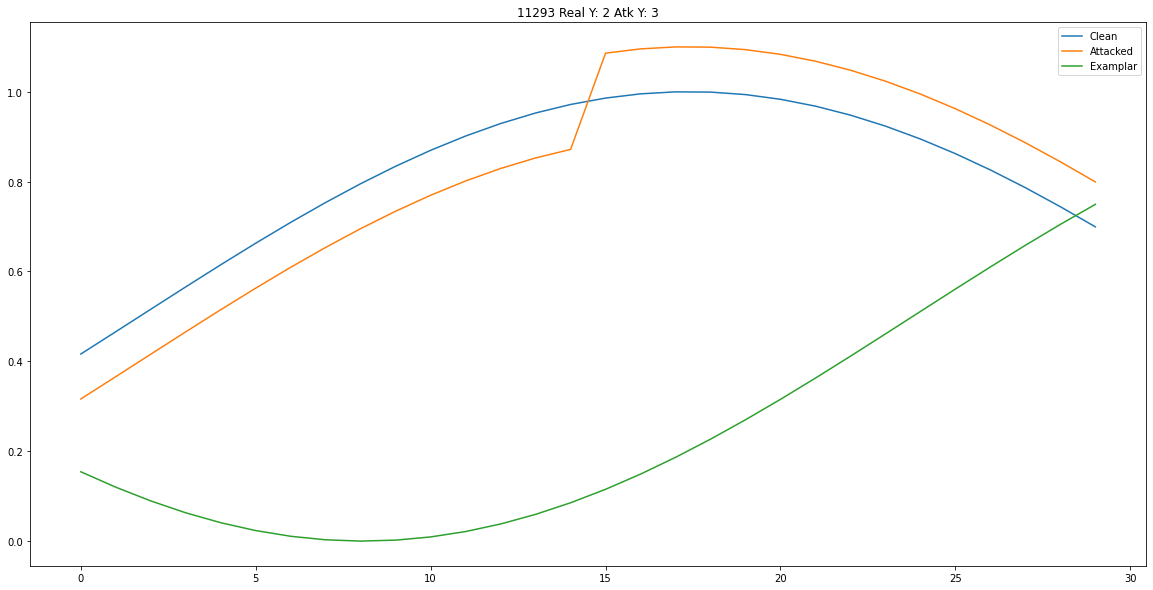

In [86]:
# look specific at why some of these are not actually miss classified
i = 11293
misses = np.where(Y_test != atk_y)[0]
plt.plot(X_test[i, 0])
plt.plot(atk[i, 0])
plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
plt.plot(X_test[examplar_ind[0], 0])
plt.legend(['Clean','Attacked','Examplar'])
# mse between the attack and the supposed actual target class
mse_base = mean_squared_error(X_test[i,0], atk[i,0])
# mse between the attack and the 'miss classification'
mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])

print(f'MSE base: %.4f, MSE target: %.4f'%(mse_base,mse_target))

Lets plot some where the MSE is larger between the mis targeted class to see what only those look like

Found 8799/19969 indexes really missclassified


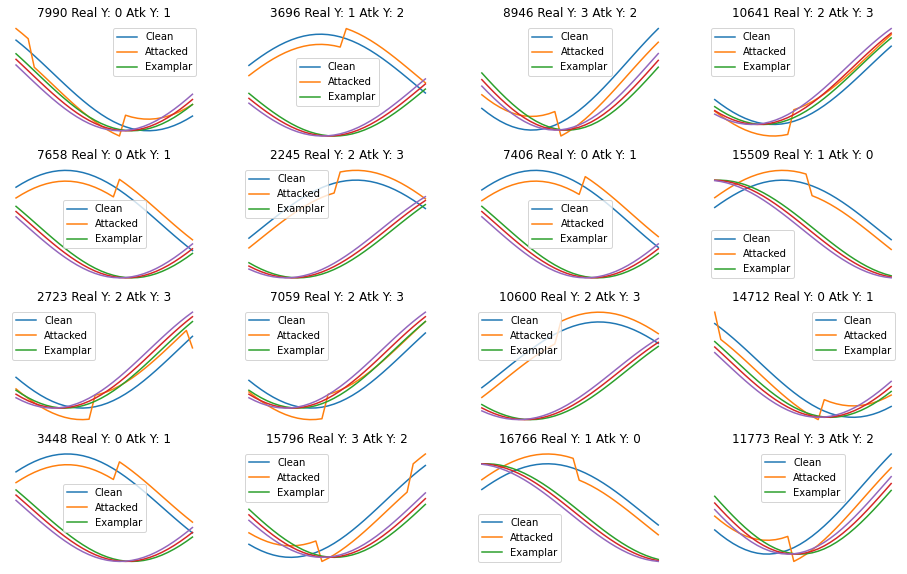

In [95]:
plt.figure(figsize=(16, 10))
misses = np.where(Y_test != atk_y)[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.plot(X_test[examplar_ind[1], 0])
        plt.plot(X_test[examplar_ind[2], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')

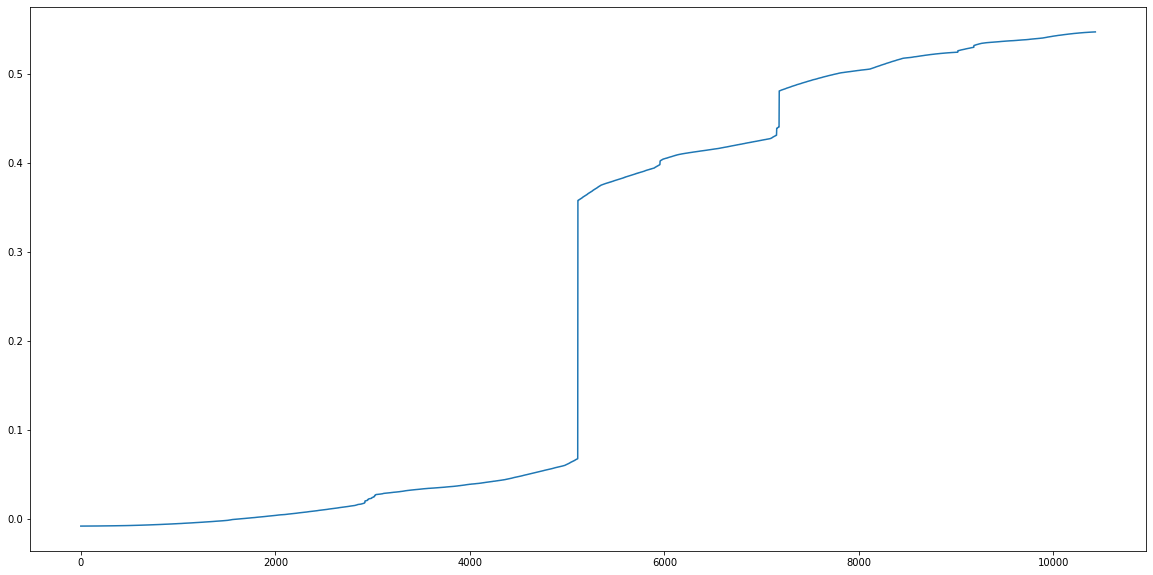

In [102]:
# now lets look at the distrobution because a lot of them will be close misclassifications like 15796 and we dont so much care about those
plt.plot(sorted(mse_values))

In [105]:
sorted(mse_values)[-16:]

[0.54748285,
 0.54749566,
 0.5474967,
 0.5474977,
 0.5475103,
 0.54751134,
 0.54751235,
 0.54752475,
 0.5475257,
 0.5475268,
 0.54753894,
 0.5475399,
 0.5475408,
 0.5475529,
 0.54755384,
 0.54755485]

Found 10432/19969 indexes really missclassified


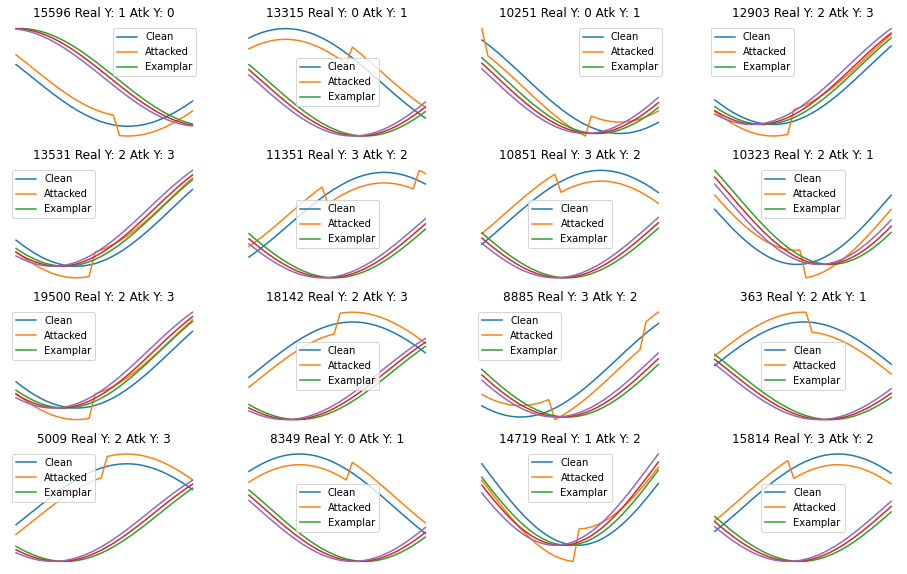

In [106]:
# lets look at the worst of the worst misclassifications
plt.figure(figsize=(16, 10))
misses = np.where(Y_test != atk_y)[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target+.547:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.plot(X_test[examplar_ind[1], 0])
        plt.plot(X_test[examplar_ind[2], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')

Found 3757/19969 indexes really missclassified


<Figure size 1152x720 with 0 Axes>

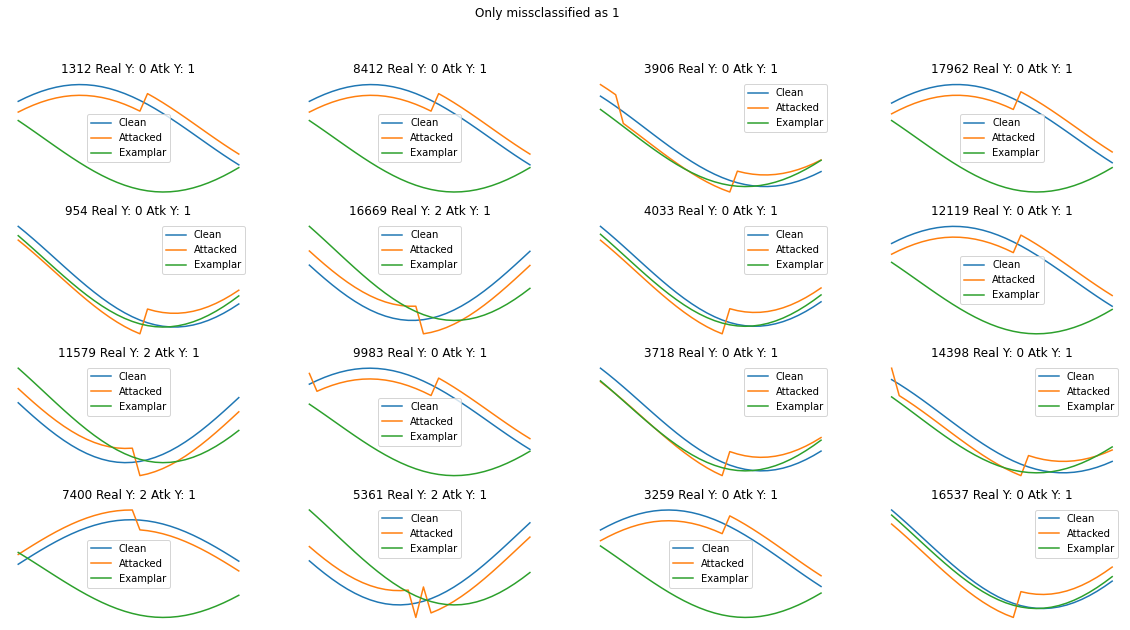

In [111]:
# I notice a pattern here, lets ONLY look at mislables of 1
plt.figure(figsize=(16, 10))
misses = np.where((Y_test != atk_y) & (atk_y == 1))[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target+.547:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
fig, ax = plt.subplots(4, 4)
fig.suptitle('Only missclassified as 1')
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')


Found 3674/19969 indexes really missclassified


<Figure size 1152x720 with 0 Axes>

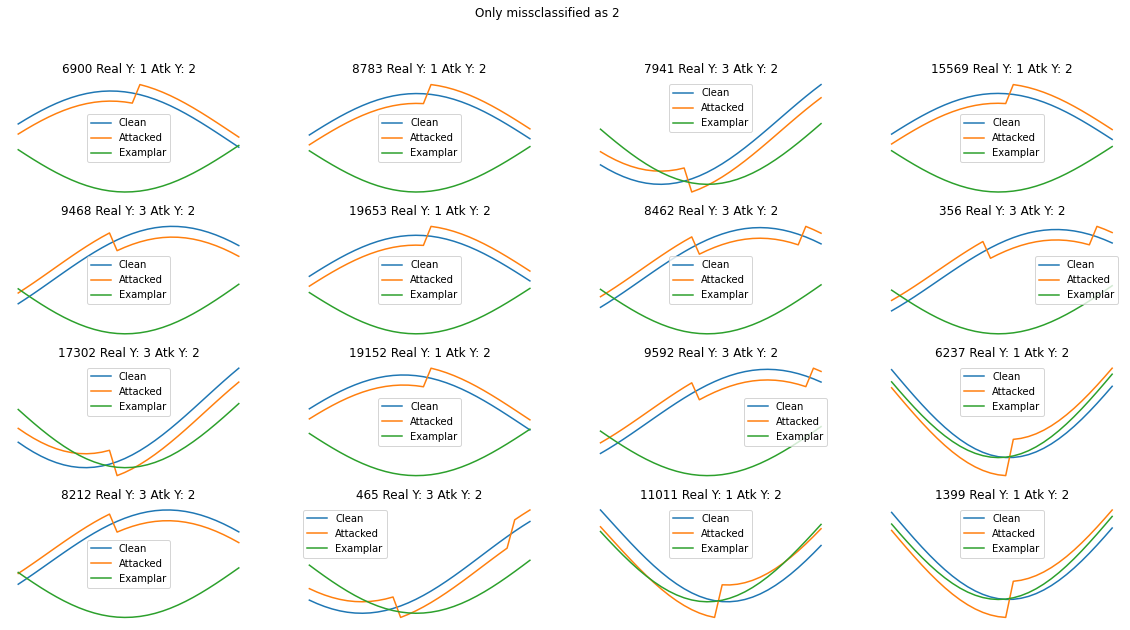

In [113]:
# I notice a pattern here, lets ONLY look at mislables of 2
plt.figure(figsize=(16, 10))
misses = np.where((Y_test != atk_y) & (atk_y ==2))[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target+.547:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
fig, ax = plt.subplots(4, 4)
fig.suptitle('Only missclassified as 2')
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')


### Conclusion #2  
It's clear to see there is a repeating pattern, given that the data is based on a sine wave this would be expected. Remember the data was going to predict the 'next' value based off the previous value, but this is a flawed idea because the 'next' value will appear 2 times in every sine wave, once on the way down and again on the way up. So, given this structure you cannot filter attacks to the point where it would provide useful predictions because the miss classification will just as many times be going in the direction of the curve as when it is not given that it is based off a sine wave. What we REALLY need is prediction based off the DIRECTION not just a single point.  
  
So in the above example 19152 might show with that example the clear downward data is miss classified as a 2 which is a more upward trend, so any algorithm based off this model would make the wrong move, but as you can see in 11011 it is the exact opposite with the same classes, this is because the predicted class is based off a single value and not a direction.  
  
Going to try again but this time with classification of direction. See proj_lstm_forecaster_simplesine_3.ipynb